In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hydroeval as he

from CompressedSensingInterpolator import CompresedSensingInterpolator
from InterpolateHelperFunctions import *

creating design matrix: 100%|██████████| 100/100 [00:00<?, ?it/s]


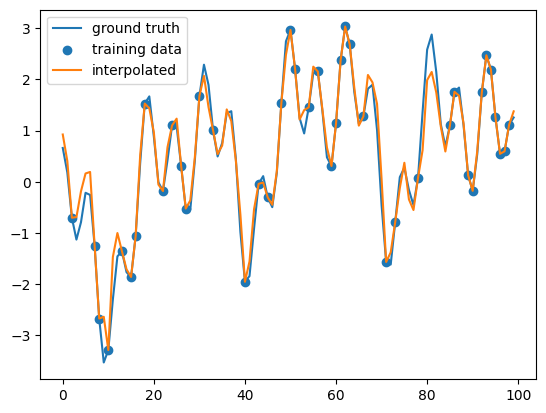

In [2]:
#examining the Compressed Sensing Interpolator using generated sinusoidal example data
numDataPoints = 100
proportionMissing = 0.9
ys, ysMissing = getExampleData(numDataPoints, proportionMissing)

#interpolating based on generated test data
method="SLSQP" # "BFGS", etc. see the method paramter here -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
interpolator = CompresedSensingInterpolator()
ysComplete = interpolator.interpolate(ysMissing, numBases=100, ys=ys, method=method)

#plotting results
plt.plot(ys, label="ground truth")
plt.scatter(np.arange(ys.shape[0]), ysMissing, label="training data")
plt.plot(ysComplete, label="interpolated")
plt.legend()
plt.show()

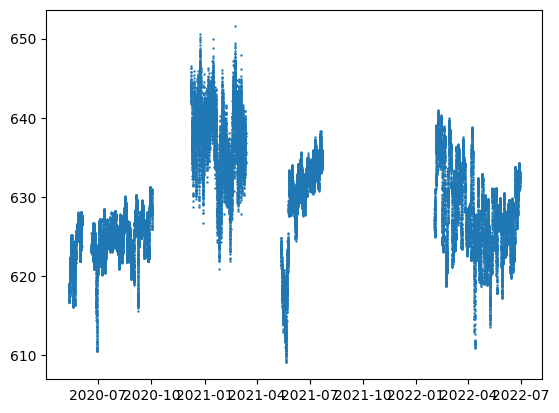

In [3]:
#importing real data and adding rows for missing days inbetween sections with pressure measurements
site_df = pd.read_csv("Ben.csv")
site_df = site_df[["datetime","pressure_hobo"]]
site_df['datetime'] =  pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
all_days = pd.DataFrame(all_days, columns=["datetime"])
site_df = all_days.merge(site_df, on='datetime', how='left')
plt.scatter(x = "datetime", y = "pressure_hobo",data=site_df, label="Filled data", s = .5)

creating design matrix: 100%|██████████| 3735/3735 [00:00<00:00, 9694.47it/s] 


NAs per column:
datetime             0.000000
index                0.899997
pressure_filled      0.899997
pressure_hobo        0.434747
pressure_combined    0.391280
dtype: float64


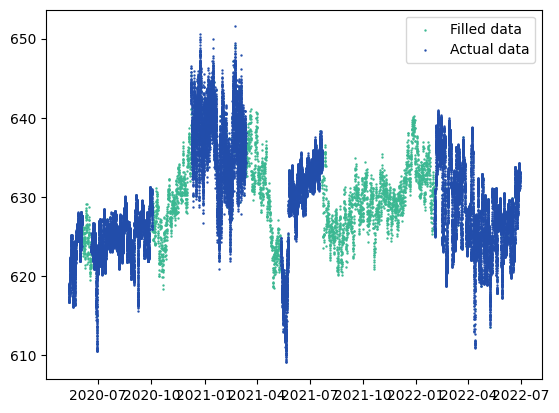

In [4]:
#using compressed sensing to interpolate every 10th measurement
sparse_joined_df = down_sample_and_interpolate_once(site_df,all_days,10,"pressure_hobo")
plt.scatter(x = "datetime", y = "pressure_filled",data=sparse_joined_df, label="Filled data", s = .5, color="#3bb892")
plt.scatter(x = "datetime", y = "pressure_hobo",data=sparse_joined_df, label="Actual data", s = .5, color="#224dab")
plt.legend()
plt.show()

Interpolating Sections


creating design matrix: 100%|██████████| 3734/3734 [00:00<00:00, 5186.30it/s]


Section failed to converge, outputting original combined column instead
datetime                    0.000000
index                       0.900094
pressure_filled             0.900094
pressure_hobo               0.000000
pressure_combined           0.000000
pressure_combined_filled    0.000000
dtype: float64
level_0                     0.099989
datetime                    0.000000
index                       0.899997
pressure_filled             0.899997
pressure_hobo               0.434747
pressure_combined           0.391280
pressure_combined_filled    0.000000
dtype: float64


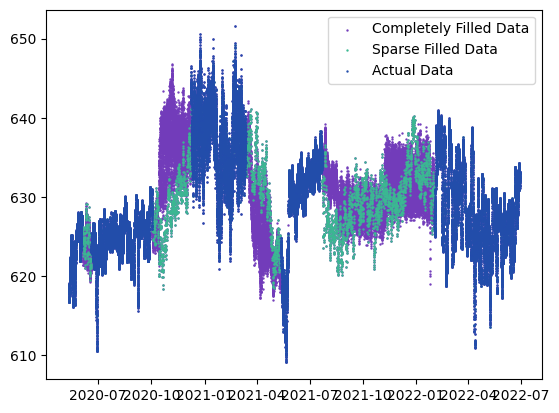

In [5]:
#filling in the remaining values using compressed sensing on 10 evenly split sections, this doesn't work so we'll need to look at other solutions
filled_joined_df = interpolate_sections(sparse_joined_df,10)

#looking at the amount of nas after interpolating in sections and at the data plotted
print(filled_joined_df.isna().sum()/filled_joined_df.shape[0])
plt.scatter(x = "datetime", y = "pressure_combined_filled",data=filled_joined_df, label="Completely Filled Data", s = .5, color="#723cba")
plt.scatter(x = "datetime", y = "pressure_filled",data=filled_joined_df, label="Sparse Filled Data", s = .5, color="#3bb892")
plt.scatter(x = "datetime", y = "pressure_hobo",data=filled_joined_df, label="Actual Data", s = .5, color="#224dab")


# left = datetime.date(2021, 7, 27)
# right = datetime.date(2021, 7, 28)

# # # Format the date into months & days
# # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y')) 
# # Changes x-axis range
# plt.gca().set_xbound(left, right)
plt.legend()
plt.show()

In [ ]:

#checking popular hydrological evaluation metrics
print("Nash-Sutcliffe Efficiency: ")
print(he.evaluator(he.nse, filled_joined_df["pressure_combined_filled"], filled_joined_df["pressure_hobo"]))
print("Percent Bias: ")
print(he.evaluator(he.pbias, filled_joined_df["pressure_combined_filled"], filled_joined_df["pressure_hobo"]))

level_0                     0.099989
datetime                    0.000000
index                       0.899997
pressure_filled             0.899997
pressure_hobo               0.434747
pressure_combined           0.391280
pressure_combined_filled    0.000000
dtype: float64


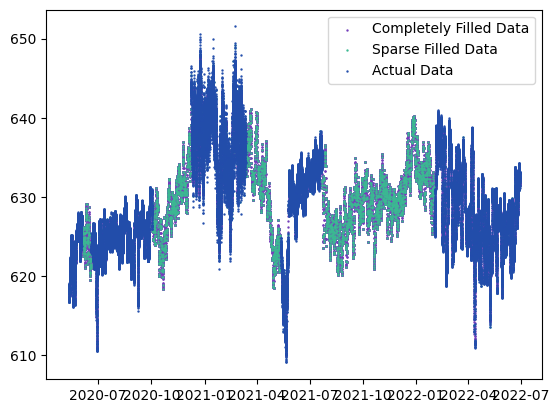

In [7]:
#using a rolling average
filled_df = sparse_joined_df
filled_df["pressure_combined_filled"] = filled_df["pressure_combined"].rolling(min_periods=1, center=True, window=12).mean()

#looking at the amount of nas per column and plotting the data
print(filled_joined_df.isna().sum()/filled_joined_df.shape[0])
plt.scatter(x = "datetime", y = "pressure_combined_filled",data=filled_df, label="Completely Filled Data", s = .5, color="#723cba")
plt.scatter(x = "datetime", y = "pressure_filled",data=filled_df, label="Sparse Filled Data", s = .5, color="#3bb892")
plt.scatter(x = "datetime", y = "pressure_hobo",data=filled_df, label="Actual Data", s = .5, color="#224dab")


# left = datetime.date(2021, 7, 27)
# right = datetime.date(2021, 8, 2)

# # # Format the date into months & days
# # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y')) 
# # Changes x-axis range
# plt.gca().set_xbound(left, right)
plt.legend()
plt.show()

0.21737325584509495
0.435318591055638


creating design matrix: 100%|██████████| 3739/3739 [00:00<00:00, 4804.36it/s]


NAs per column:
datetime             0.000000
index                0.899997
pressure_filled      0.899997
pressure_hobo        0.869533
pressure_combined    0.782520
dtype: float64
datetime                    0.000000
index                       0.899997
pressure_filled             0.899997
pressure_hobo               0.869533
pressure_combined           0.782520
pressure_combined_filled    0.000013
dtype: float64
Nash-Sutcliffe Efficiency: 
[0.99036879]
Percent Bias: 
[-0.00017892]


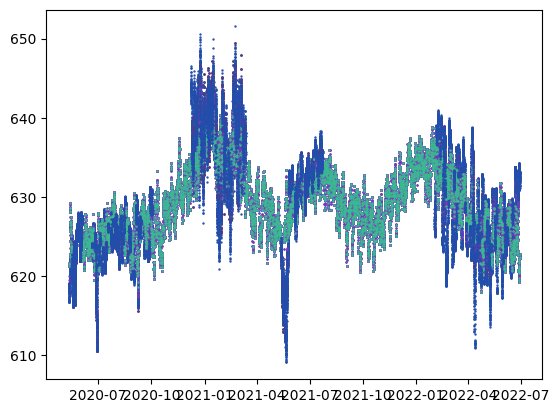

In [10]:
#generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
test_df = get_test_df(site_df)

#using compressed sensing to fill in every 10th measurement
sparse_joined_test_df = down_sample_and_interpolate_once(test_df,all_days,10,"pressure_hobo")

#filling in the rest of the pressure data using a rolling average
filled_test_df = sparse_joined_test_df
filled_test_df["pressure_combined_filled"] = filled_test_df["pressure_combined"].rolling(min_periods=1, center=True, window=12).mean()

#looking at the amount of nas and the data plotted
print(filled_test_df.isna().sum()/filled_test_df.shape[0])
plt.scatter(x = "datetime", y = "pressure_combined_filled",data=filled_test_df, label="Completely Filled Data", s = .5, color="#723cba")
plt.scatter(x = "datetime", y = "pressure_filled",data=filled_test_df, label="Sparse Filled Data", s = .5, color="#3bb892")
plt.scatter(x = "datetime", y = "pressure_hobo",data=filled_test_df, label="Actual Data", s = .5, color="#224dab")

#checking popular hydrological evaluation metrics
print("Nash-Sutcliffe Efficiency: ")
print(he.evaluator(he.nse, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"]))
print("Percent Bias: ")
print(he.evaluator(he.pbias, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"]))